In [2]:
# Análisis de Clasificación para Datos de Cáncer de Mama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_auc_score, 
                           roc_curve, precision_recall_curve)
from sklearn.decomposition import PCA
import joblib

In [4]:
# 1. Carga y preparación de datos
df = pd.read_csv('breast-cancer.csv')
df.drop('id', axis=1, inplace=True)

In [5]:
# Codificar diagnóstico (M=1, B=0)
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

In [6]:
# Separar características y objetivo
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [7]:
# Estandarizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Dividir datos (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [10]:
# 2. Creación y optimización del modelo
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [12]:
# 3. Evaluación del modelo
y_pred = best_rf.predict(X_test)
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Métricas ===")
print(f"Exactitud: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


=== Métricas ===
Exactitud: 0.9708
AUC-ROC: 0.9971

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       108
           1       0.98      0.94      0.96        63

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



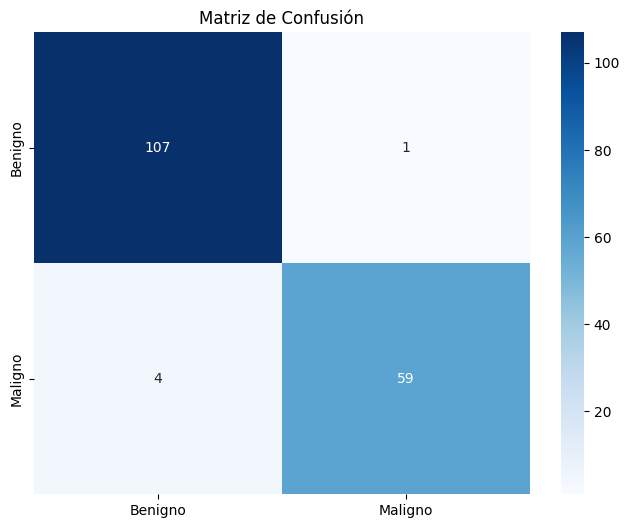

In [13]:
# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno', 'Maligno'], 
            yticklabels=['Benigno', 'Maligno'])
plt.title('Matriz de Confusión')
plt.show()

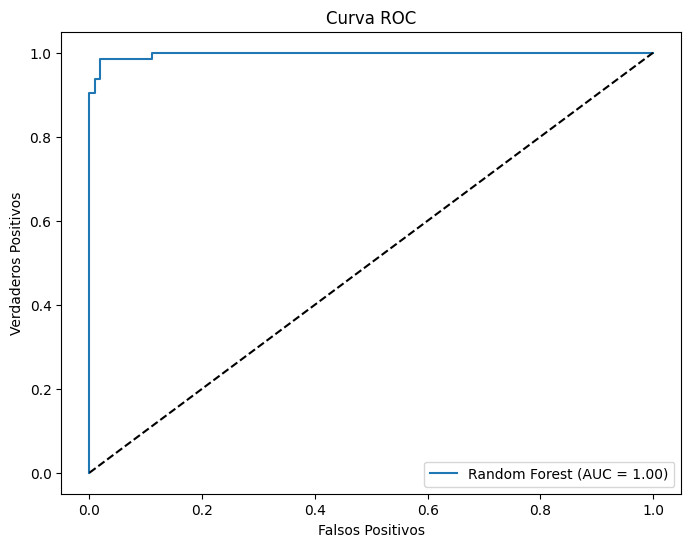

In [14]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

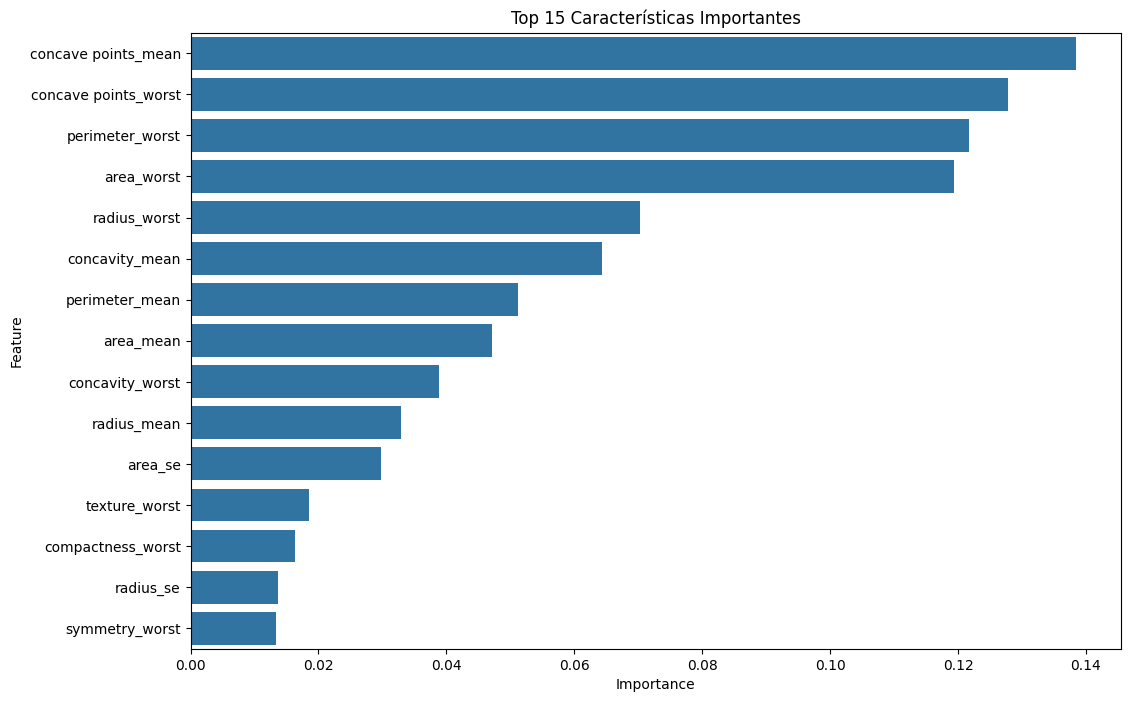

In [15]:
# Importancia de características
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Características Importantes')
plt.show()

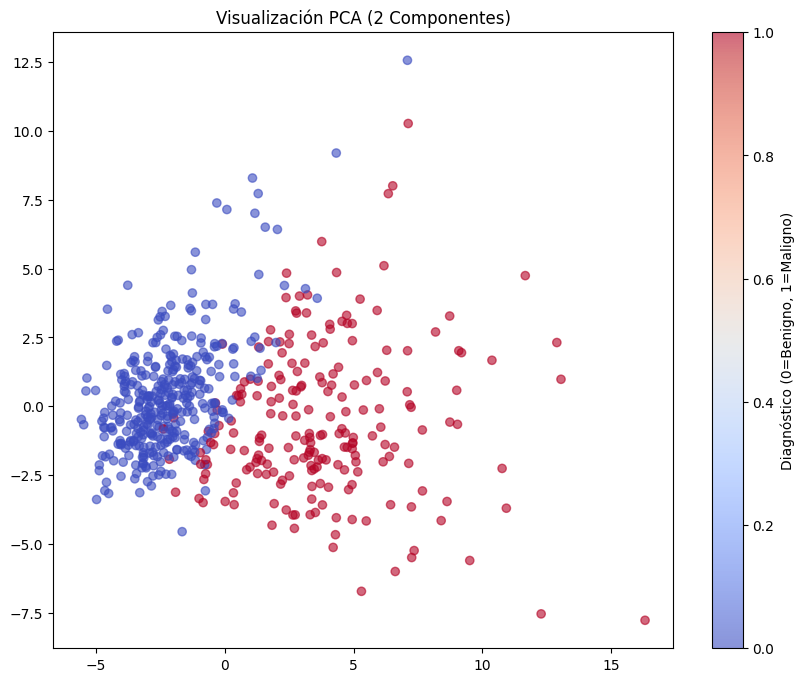


Modelo guardado como 'breast_cancer_rf_model.pkl'


In [16]:
# Visualización PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title('Visualización PCA (2 Componentes)')
plt.colorbar(label='Diagnóstico (0=Benigno, 1=Maligno)')
plt.show()

# Guardar modelo
joblib.dump(best_rf, 'breast_cancer_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nModelo guardado como 'breast_cancer_rf_model.pkl'")